In [1]:
%matplotlib inline

from copy import deepcopy

import torch
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis, flop_count_table, ActivationCountAnalysis

# DeTR imports
from deperceiver.models.backbone import build_backbone
from deperceiver.models.transformer import build_transformer
from deperceiver.models.detr import DETR

# DePerceiver imports
from deperceiver.models.naive_deperceiver import NaiveDePerceiver
from deperceiver.models.perceiver_io import PerceiverDecoder, PerceiverEncoder, PerceiverIO, PerceiverMultipleDecoder

In [2]:
sample_image = torch.zeros((1, 3, 800, 800))

DePerceiver Flop Counts
=======================

In [3]:
def build_deperceiver(args):
    backbone = build_backbone(args)

    perceiver_encoder = PerceiverEncoder(
        num_latents=args.num_latents,
        latent_dim=256,
        input_dim=256,
        num_self_attn_per_block=args.enc_layers_per_block,
        num_blocks=args.enc_blocks,
        num_cross_attn_heads=1,
        num_self_attn_heads=8,
        cross_attn_widening_factor=1,
        self_attn_widening_factor=1,
    )

    perceiver_decoder = PerceiverDecoder(
        latent_dim=256,
        query_dim=256,
    )

    perceiver = PerceiverIO(
        perceiver_encoder, perceiver_decoder
    )

    model = NaiveDePerceiver(
        backbone,
        perceiver,
        None,
        num_classes=91,
        num_queries=args.num_queries,
        args=args,
    )
    
    return model

In [4]:
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)

In [5]:
dp_base_args = objdict()
dp_base_args.lr = 1e-4
dp_base_args.lr_backbone = 1e-5
dp_base_args.batch_size = 2
dp_base_args.weight_decay = 1e-4
dp_base_args.epochs = 50
dp_base_args.lr_drop = 33
dp_base_args.clip_max_norm = 0.1
dp_base_args.backbone = "resnet50"
dp_base_args.dilation = False
dp_base_args.position_embedding = "sine"
dp_base_args.num_latents = 1024
dp_base_args.enc_blocks = 3
dp_base_args.enc_layers_per_block = 6
dp_base_args.dec_layers = 3
dp_base_args.hidden_dim = 256
dp_base_args.num_queries = 100
dp_base_args.masks = False
dp_base_args.aux_loss = False

In [6]:
dp_args_32 = deepcopy(dp_base_args)
dp_args_32.downsample_factor = 32
dp_32 = build_deperceiver(dp_args_32)

# dp_32_fc = FlopCountAnalysis(dp_32, sample_image)
# dp_32_flops = dp_32_fc.total()

dp_32_acts = ActivationCountAnalysis(dp_32, sample_image)

In [7]:
dp_args_16 = deepcopy(dp_base_args)
dp_args_16.downsample_factor = 16
dp_16 = build_deperceiver(dp_args_16)

# dp_16_fc = FlopCountAnalysis(dp_16, sample_image)
# dp_16_flops = dp_16_fc.total()

dp_16_acts = ActivationCountAnalysis(dp_16, sample_image)

In [8]:
dp_args_8 = deepcopy(dp_base_args)
dp_args_8.downsample_factor = 8
dp_8 = build_deperceiver(dp_args_8)

# dp_8_fc = FlopCountAnalysis(dp_8, sample_image)
# dp_8_flops = dp_8_fc.total()

dp_8_acts = ActivationCountAnalysis(dp_8, sample_image)

DeTR Flop Counts
================

In [9]:
def build_detr(args):
    backbone = build_backbone(args)
    transformer = build_transformer(args)

    model = DETR(
        backbone,
        transformer,
        None,
        num_classes=91,
        num_queries=args.num_queries,
        args=args,
        aux_loss=args.aux_loss,
    )
    
    return model

In [10]:
dt_base_args = objdict()
dt_base_args.lr = 1e-4
dt_base_args.lr_backbone = 1e-5
dt_base_args.batch_size = 2
dt_base_args.weight_decay = 1e-4
dt_base_args.epochs = 50
dt_base_args.lr_drop = 33
dt_base_args.clip_max_norm = 0.1
dt_base_args.backbone = "resnet50"
dt_base_args.dilation = False
dt_base_args.position_embedding = "sine"
dt_base_args.enc_layers = 6
dt_base_args.dec_layers = 6
dt_base_args.dim_feedforward = 2048
dt_base_args.hidden_dim = 256
dt_base_args.nheads = 8
dt_base_args.dropout = 0.1
dt_base_args.pre_norm = False
dt_base_args.num_queries = 100
dt_base_args.masks = False
dt_base_args.aux_loss = False

In [11]:
dt_args_32 = deepcopy(dt_base_args)
dt_args_32.downsample_factor = 32
dt_32 = build_detr(dt_args_32)

# dt_32_fc = FlopCountAnalysis(dt_32, sample_image)
# dt_32_flops = dt_32_fc.total()

dt_32_acts = ActivationCountAnalysis(dt_32, sample_image)

In [12]:
dt_args_16 = deepcopy(dt_base_args)
dt_args_16.downsample_factor = 16
dt_16 = build_detr(dt_args_16)

# dt_16_fc = FlopCountAnalysis(dt_16, sample_image)
# dt_16_flops = dt_16_fc.total()

dt_16_acts = ActivationCountAnalysis(dt_16, sample_image)

In [13]:
dt_args_8 = deepcopy(dt_base_args)
dt_args_8.downsample_factor = 8
dt_8 = build_detr(dt_args_8)

# dt_8_fc = FlopCountAnalysis(dt_8, sample_image)
# dt_8_flops = dt_8_fc.total()

dt_8_acts = ActivationCountAnalysis(dt_8, sample_image)

Summary
=======

In [14]:
def p_acts(acts):
    return acts.by_module()["perceiver"]

def t_acts(acts):
    return acts.by_module()["transformer"]

In [15]:
dp_acts = [p_acts(dp_32_acts), p_acts(dp_16_acts), p_acts(dp_8_acts)]
dt_acts = [t_acts(dt_32_acts), t_acts(dt_16_acts), t_acts(dt_8_acts)]

/home/edwardli/miniconda3/envs/pt_lightning/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Unsupported operator aten::sub encountered 56 time(s)
Unsupported operator aten::add encountered 149 time(s)
Unsupported operator aten::rsqrt encountered 53 time(s)
Unsupported operator aten::mul encountered 423 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 16 time(s)
Unsupported operator aten::upsample_nearest2d en

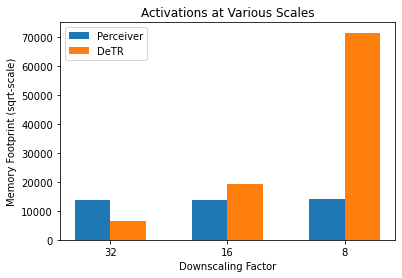

In [32]:
import numpy as np

dp_acts = np.array(dp_acts)
dt_acts = np.array(dt_acts)

plt.bar(np.arange(3), np.sqrt(dp_acts), width=0.3)
plt.bar(np.arange(3)+0.3, np.sqrt(dt_acts), width=0.3)
plt.xticks(np.arange(3)+0.15, ['32', '16', '8'])

plt.legend(['Perceiver', 'DeTR'])

plt.xlabel("Downscaling Factor")
plt.ylabel("Memory Footprint (sqrt-scale)")

plt.title("Activations at Various Scales")

plt.savefig("activation.svg")
plt.show()